In [1]:
import prophet

In [2]:
import pandas as pd
import numpy as np
from matplotlib import rc
import platform
import matplotlib.pyplot as plt
import seaborn as sns
if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin': # Mac
    rc('font', family='AppleGothic')
else: #linux
    rc('font', family='NanumGothic')
    
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 현상 해결 코드

In [3]:
train= pd.read_csv("train.csv")
trade  = pd.read_csv("international_trade.csv")
sample = pd.read_csv("sample_submission.csv")
test = pd.read_csv("test.csv")

# 날짜 변수를 이용해 supply예측하기

### 감귤

In [14]:
# 함수 모음집
from sklearn.metrics import mean_squared_error
import datetime

# 전처리 함수
def pre(df):
    # 년,월,일 변수 생성 및 timestamp변수 삭제
    ## 주차 변수 생성
    df["week"] = df["timestamp"].map(lambda x:datetime.datetime(int(x[:4]),int(x[5:7]),int(x[8:])).isocalendar()[1])
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["year"] = df["timestamp"].dt.year
    df["month"] = df["timestamp"].dt.month
    df["day"] = df["timestamp"].dt.day
    df["weekday"] = df["timestamp"].dt.weekday

    # 주말 변수 추가(토 일 주말)
    df["weekend"] = df["weekday"].map(lambda x: 1 if x in [6] else 0)

    # 필요없는 변수 삭제
    df = df.drop(columns = ["item", "price"])
    # # 0값 삭제
    # df = df[df["supply"]!=0]
    


    # 더미 변수화
    df = pd.get_dummies(df, columns = ["corporation", "location"], drop_first=True)
    return df


# 데이터 나누기
def train_test_split_ts(df, test_size, test):
    if test:
        df_train = df[~df["supply"].isnull()]
        df_test = df[df["supply"].isnull()]

        train_x = df_train.drop(columns = ["supply", "timestamp"])
        train_y = df_train['supply']
        test_y = df_test.drop(columns = ["supply", "timestamp"])
        return train_x, train_y, test_y


    else:
        x_train, x_valid = np.split(train_x, [int(len(df)*(1-test_size))])
        y_train, y_valid = np.split(train_y, [int(len(df)*(1-test_size))])
        t_time_train, y_time_valid  = np.split(y, [int(len(df)*(1-test_size))])
        return x_train, x_valid, y_train, y_valid,  y_time_valid

from sklearn.metrics import mean_squared_error

df = pd.read_csv("train.csv")


def item_supply_predict(df,model, test_size=0.2, test = False):
    item = df.item.unique().tolist()[0]
    
    # 컬럼명 바꾸기
    df = df.rename(columns = {"supply(kg)" : "supply", "price(원/kg)" : "price"})

    # 데이터 전처리하기
    df = pre(df)

    # 정렬
    df = df.sort_values(by = "timestamp")

    # 데이터 나누기
    if test:
        x_train ,y_train, x_valid = train_test_split_ts(df, test_size, test)
    else:
        x_train, x_valid, y_train, y_valid, y = train_test_split_ts(df, test_size, test)


    # 모델
    modelnm = model.__class__.__name__
    model.fit(x_train, y_train)

    pred = model.predict(x_valid)
    
    # 0이하의 값 0으로 처리하기
    for idx in range(len(pred)):
        if pred[idx]<0:
            pred[idx]=0
    
    if test:
        return pred
    else:
        print(f"{item}의 {modelnm} RMSE : {np.sqrt(mean_squared_error(y_valid, pred))}")
        return y_valid, y, pred, model





In [235]:
result = {}
for i in train.item.unique():
    df = pd.concat([train[train["item"]==i], test[test["item"]==i]])
    df = df.rename(columns = {"supply(kg)" : "supply", "price(원/kg)" : "price"})

    # 데이터 전처리하기
    df = pre(df)

    # 정렬
    df = df.sort_values(by = "timestamp")

    df_train = df[~df["supply"].isnull()]
    df_test = df[df["supply"].isnull()]

    y_train = df_train["supply"]
    x_train = df_train.drop(columns = ["ID", "supply", "timestamp"])

    y_test = df_test.drop(columns= ["ID", "supply", "timestamp"])
    y = pd.DataFrame(df_test["ID"]).reset_index(drop = True)

    xgb = XGBRegressor()
    xgb.fit(x_train, y_train)

    pred = xgb.predict(y_test)

    for idx in range(len(pred)):
        if pred[idx]<0:
            pred[idx]=0

    pred = pd.DataFrame(pred, columns = ["pred"])
    y_new = pd.concat([y, pred], axis = 1)
    
    result[i] = y_new

In [240]:
# output
old = result["TG"]
for i in ['CR', 'CB', 'RD', 'BC']:
    new = pd.concat([old, result[i]])
    old = new
predict_supply = new.sort_values("ID")
predict_supply.to_csv("predict_supply.csv")

### trade로 supply 예측

In [20]:
# 함수 모음집

# 전처리 함수
def pre(df):
    # 년,월,일 변수 생성 및 timestamp변수 삭제
    ## 주차 변수 생성
    df["week"] = df["timestamp"].map(lambda x:datetime.datetime(int(x[:4]),int(x[5:7]),int(x[8:])).isocalendar()[1])
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["year"] = df["timestamp"].dt.year
    df["month"] = df["timestamp"].dt.month
    df["day"] = df["timestamp"].dt.day
    df["weekday"] = df["timestamp"].dt.weekday
    # df["price_ox"] = df["supply"].map(lambda x:0 if x!=0 else 1)

    # 주말 변수 추가(토 일 주말)
    df["weekend"] = df["weekday"].map(lambda x: 1 if x in [6] else 0)

    # 필요없는 변수 삭제
    df = df.drop(columns = ["ID", "item", "price"])
    # # 0값 삭제
    # df = df[df["supply"]!=0]
    


    # 더미 변수화
    df = pd.get_dummies(df, columns = ["corporation", "location"], drop_first=True)
    return df


# 데이터 나누기
def train_test_split_ts (df, test_size):
    train_x = df.drop(columns = ["supply", "timestamp"])
    train_y = df['supply']
    y = df[["timestamp" , 'supply']]

    x_train, x_valid = np.split(train_x, [int(len(df)*(1-test_size))])
    y_train, y_valid = np.split(train_y, [int(len(df)*(1-test_size))])
    t_time_train, y_time_valid  = np.split(y, [int(len(df)*(1-test_size))])
    return x_train, x_valid, y_train, y_valid,  y_time_valid

In [419]:
def train_test_split_ts (df, test_size):
    train_x = df.drop(columns = ["supply", "timestamp"])
    train_y = df['supply']
    y = df[["timestamp" , 'supply']]

    x_train, x_valid = np.split(train_x, [int(len(df)*(1-test_size))])
    y_train, y_valid = np.split(train_y, [int(len(df)*(1-test_size))])
    t_time_train, y_time_valid  = np.split(y, [int(len(df)*(1-test_size))])
    return x_train, x_valid, y_train, y_valid,  y_time_valid

##### 감귤

- TG : 감귤
- BC : 꽃양배추와 브로콜리(broccoli)
- RD : 순무
- CR : 당근
- CB : 방울다다기 양배추, 양배추

In [134]:
train = pd.read_csv("train.csv")
trade = pd.read_csv("international_trade.csv")
trade.head(5)

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


In [135]:
# 데이터 전처리
train = train.rename(columns = {"supply(kg)" : "supply", "price(원/kg)" : "price"})
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["year"] = train["timestamp"].dt.year
train["month"] = train["timestamp"].dt.month

trade["기간"] = pd.to_datetime(trade["기간"], format = "%Y-%m", errors='coerce')

In [136]:
# 합치기 
train_tg = train[train["item"] == "TG"]
trade_tg = trade[trade["품목명"] == "감귤"]


In [137]:
trade_tg
trade_tg.loc[len(trade_tg)+1, "기간"] = pd.to_datetime("2023-03-01")

C:\Users\sybae\AppData\Local\Temp\ipykernel_16080\1254590252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_tg.loc[len(trade_tg)+1, "기간"] = pd.to_datetime("2023-03-01")


In [138]:
trade_tg["수출 금액"] = trade_tg["수출 금액"].shift(1)
trade_tg["year"] = trade_tg["기간"].dt.year
trade_tg["month"] = trade_tg["기간"].dt.month

In [139]:
trade_tg.tail(5)

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지,year,month
1187,2022-11-01,감귤,1382242.0,118.0,0.0,0.0,1406.0,2022,11
1210,2022-12-01,감귤,1537517.0,1406.0,17600.0,22.0,1374.0,2022,12
1236,2023-01-01,감귤,81509.0,1396.0,0.0,0.0,269.0,2023,1
1264,2023-02-01,감귤,6895.0,269.0,27765.0,98.0,-64.0,2023,2
51,2023-03-01,NaN,NaN,34.0,NaN,NaN,NaN,2023,3


In [140]:
df_tg = pd.merge(train_tg, trade_tg, how ="left", on=["year", "month"]).drop(columns = ["year", "month", "기간", "수출 중량", "수입 중량", "수입 금액", "무역수지"])

In [141]:
df_tg = df_tg.sort_values("timestamp")

In [142]:
df_tg["timestamp"] = df_tg["timestamp"].astype("str")

In [143]:
df_tg["timestamp"] = df_tg["timestamp"].astype("str")
df_new = pre(df_tg)
df_new.head(5)

,timestamp,supply,품목명,수출 금액,week,year,month,day,weekday,weekend,corporation_B,corporation_C,corporation_D,corporation_E,location_S
0,2019-01-01,0.0,감귤,NaN,1,2019,1,1,1,0,0,0,0,0,0
6092,2019-01-01,0.0,감귤,NaN,1,2019,1,1,1,0,0,1,0,0,0
3046,2019-01-01,0.0,감귤,NaN,1,2019,1,1,1,0,1,0,0,0,0
7615,2019-01-01,0.0,감귤,NaN,1,2019,1,1,1,0,0,1,0,0,1
9138,2019-01-01,0.0,감귤,NaN,1,2019,1,1,1,0,0,0,1,0,0


In [144]:
df_new = df_new.drop(columns = [ "품목명" ])

In [145]:
df_new

,timestamp,supply,수출 금액,week,year,month,day,weekday,weekend,corporation_B,corporation_C,corporation_D,corporation_E,location_S
0,2019-01-01,0.0,NaN,1,2019,1,1,1,0,0,0,0,0,0
6092,2019-01-01,0.0,NaN,1,2019,1,1,1,0,0,1,0,0,0
3046,2019-01-01,0.0,NaN,1,2019,1,1,1,0,1,0,0,0,0
7615,2019-01-01,0.0,NaN,1,2019,1,1,1,0,0,1,0,0,1
9138,2019-01-01,0.0,NaN,1,2019,1,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4568,2023-03-03,3027.0,34.0,9,2023,3,3,4,0,1,0,0,0,0
3045,2023-03-03,35016.0,34.0,9,2023,3,3,4,0,0,0,0,0,1
1522,2023-03-03,10343.6,34.0,9,2023,3,3,4,0,0,0,0,0,0
13706,2023-03-03,3360.0,34.0,9,2023,3,3,4,0,0,0,0,1,0


In [146]:
x_train, x_valid, y_train, y_valid, y = train_test_split_ts(df_new, 0.2)

In [148]:
y

,timestamp,supply
2741,2022-05-03,3569.0
10356,2022-05-03,600.0
13402,2022-05-03,0.0
5787,2022-05-03,3447.0
11879,2022-05-03,954.0
...,...,...
4568,2023-03-03,3027.0
3045,2023-03-03,35016.0
1522,2023-03-03,10343.6
13706,2023-03-03,3360.0


In [149]:
x_train

,수출 금액,week,year,month,day,weekday,weekend,corporation_B,corporation_C,corporation_D,corporation_E,location_S
0,NaN,1,2019,1,1,1,0,0,0,0,0,0
6092,NaN,1,2019,1,1,1,0,0,1,0,0,0
3046,NaN,1,2019,1,1,1,0,1,0,0,0,0
7615,NaN,1,2019,1,1,1,0,0,1,0,0,1
9138,NaN,1,2019,1,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7309,1.0,18,2022,5,2,0,0,0,1,0,0,0
1218,1.0,18,2022,5,3,1,0,0,0,0,0,0
7310,1.0,18,2022,5,3,1,0,0,1,0,0,0
14925,1.0,18,2022,5,3,1,0,0,0,0,1,1


In [152]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators = 50, random_state = 2024, learning_rate = 0.1, max_leaves = 10, )
xgb.fit(x_train, y_train)
pred = xgb.predict(x_valid)
for idx in range(len(pred)):
    if pred[idx]<0:
        pred[idx]=0

In [153]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_valid, pred))

13949.43384714935

### 수출 빼기

In [154]:
train_tg = train[train["item"] =="TG"]
train_tg["timestamp"] = train_tg["timestamp"].astype("str")
train_tg = train_tg.sort_values("timestamp")
train_tg = pre(train_tg)

C:\Users\sybae\AppData\Local\Temp\ipykernel_16080\875328836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tg["timestamp"] = train_tg["timestamp"].astype("str")


In [155]:
train_tg

,timestamp,supply,year,month,week,day,weekday,weekend,corporation_B,corporation_C,corporation_D,corporation_E,location_S
0,2019-01-01,0.0,2019,1,1,1,1,0,0,0,0,0,0
6092,2019-01-01,0.0,2019,1,1,1,1,0,0,1,0,0,0
3046,2019-01-01,0.0,2019,1,1,1,1,0,1,0,0,0,0
7615,2019-01-01,0.0,2019,1,1,1,1,0,0,1,0,0,1
9138,2019-01-01,0.0,2019,1,1,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4568,2023-03-03,3027.0,2023,3,9,3,4,0,1,0,0,0,0
3045,2023-03-03,35016.0,2023,3,9,3,4,0,0,0,0,0,1
1522,2023-03-03,10343.6,2023,3,9,3,4,0,0,0,0,0,0
13706,2023-03-03,3360.0,2023,3,9,3,4,0,0,0,0,1,0


In [203]:
train_tg[train_tg["timestamp"]<"2022-02-03"]

,timestamp,supply,year,month,week,day,weekday,weekend,corporation_B,corporation_C,corporation_D,corporation_E,location_S
0,2019-01-01,0.0,2019,1,1,1,1,0,0,0,0,0,0
6092,2019-01-01,0.0,2019,1,1,1,1,0,0,1,0,0,0
3046,2019-01-01,0.0,2019,1,1,1,1,0,1,0,0,0,0
7615,2019-01-01,0.0,2019,1,1,1,1,0,0,1,0,0,1
9138,2019-01-01,0.0,2019,1,1,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13312,2022-02-02,0.0,2022,2,5,2,2,0,0,0,0,1,0
14835,2022-02-02,0.0,2022,2,5,2,2,0,0,0,0,1,1
2651,2022-02-02,0.0,2022,2,5,2,2,0,0,0,0,0,1
8743,2022-02-02,0.0,2022,2,5,2,2,0,0,1,0,0,1


In [201]:
x_train_no, x_valid_no, y_train_no, y_valid_no, y_no = train_test_split_ts(train_tg, 0.2)
y_no

,timestamp,supply
2741,2022-05-03,3569.0
10356,2022-05-03,600.0
13402,2022-05-03,0.0
5787,2022-05-03,3447.0
11879,2022-05-03,954.0
...,...,...
4568,2023-03-03,3027.0
3045,2023-03-03,35016.0
1522,2023-03-03,10343.6
13706,2023-03-03,3360.0


In [157]:
x_train

,수출 금액,week,year,month,day,weekday,weekend,corporation_B,corporation_C,corporation_D,corporation_E,location_S
0,NaN,1,2019,1,1,1,0,0,0,0,0,0
6092,NaN,1,2019,1,1,1,0,0,1,0,0,0
3046,NaN,1,2019,1,1,1,0,1,0,0,0,0
7615,NaN,1,2019,1,1,1,0,0,1,0,0,1
9138,NaN,1,2019,1,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7309,1.0,18,2022,5,2,0,0,0,1,0,0,0
1218,1.0,18,2022,5,3,1,0,0,0,0,0,0
7310,1.0,18,2022,5,3,1,0,0,1,0,0,0
14925,1.0,18,2022,5,3,1,0,0,0,0,1,1


In [204]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators = 50, random_state = 2024, learning_rate = 0.1, max_leaves = 10)
xgb.fit(x_train_no, y_train_no)
pred = xgb.predict(x_valid_no)
for idx in range(len(pred)):
    if pred[idx]<0:
        pred[idx]=0

In [205]:
from sklearn.metrics import mean_squared_error

rmse_no_exp = np.sqrt(mean_squared_error(y_valid_no, pred))

In [206]:
rmse_no_exp

10723.572030763231

In [207]:
### early stopping 
from xgboost import XGBRegressor
evals = [(x_valid_no, y_valid_no)]

xgb_wrapper = XGBRegressor(n_estimators = 500, random_state = 2024, learning_rate = 0.01, max_leaves = 10)
xgb_wrapper.fit(x_train_no, y_train_no, early_stopping_rounds =500, eval_set = evals, eval_metric = "rmse", verbose=True)




[0]	validation_0-rmse:25373.57902
[1]	validation_0-rmse:25161.54353
[2]	validation_0-rmse:24952.22877
[3]	validation_0-rmse:24745.61155
[4]	validation_0-rmse:24528.47349
[5]	validation_0-rmse:24315.86819
[6]	validation_0-rmse:24104.60762
[7]	validation_0-rmse:23898.07217


[8]	validation_0-rmse:23691.92827
[9]	validation_0-rmse:23487.73949
[10]	validation_0-rmse:23289.15849
[11]	validation_0-rmse:23089.28857
[12]	validation_0-rmse:22895.80347
[13]	validation_0-rmse:22702.43804
[14]	validation_0-rmse:22515.10097
[15]	validation_0-rmse:22325.23344
[16]	validation_0-rmse:22143.24438
[17]	validation_0-rmse:21958.33536
[18]	validation_0-rmse:21781.17355
[19]	validation_0-rmse:21600.00614
[20]	validation_0-rmse:21426.67250
[21]	validation_0-rmse:21252.72724
[22]	validation_0-rmse:21081.12772
[23]	validation_0-rmse:20913.62392
[24]	validation_0-rmse:20748.35597
[25]	validation_0-rmse:20601.75350
[26]	validation_0-rmse:20436.73224


c:\Users\sybae\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\sybae\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-rmse:20279.08522
[28]	validation_0-rmse:20119.35037
[29]	validation_0-rmse:19979.41253
[30]	validation_0-rmse:19824.60731
[31]	validation_0-rmse:19688.35207
[32]	validation_0-rmse:19540.15583
[33]	validation_0-rmse:19392.31221
[34]	validation_0-rmse:19244.32991
[35]	validation_0-rmse:19117.65971
[36]	validation_0-rmse:18977.30393
[37]	validation_0-rmse:18852.53158
[38]	validation_0-rmse:18712.67688
[39]	validation_0-rmse:18575.24990
[40]	validation_0-rmse:18457.69902
[41]	validation_0-rmse:18324.73449
[42]	validation_0-rmse:18196.51249
[43]	validation_0-rmse:18068.05145
[44]	validation_0-rmse:17954.85053
[45]	validation_0-rmse:17832.43764
[46]	validation_0-rmse:17723.16837
[47]	validation_0-rmse:17602.38027
[48]	validation_0-rmse:17484.83307
[49]	validation_0-rmse:17366.30310
[50]	validation_0-rmse:17264.58373
[51]	validation_0-rmse:17150.13745
[52]	validation_0-rmse:17050.19799
[53]	validation_0-rmse:16941.84783
[54]	validation_0-rmse:16833.66181
[55]	validation_0-rm

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=10,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2024, ...)

In [208]:
pred = xgb_wrapper.predict(x_valid_no)

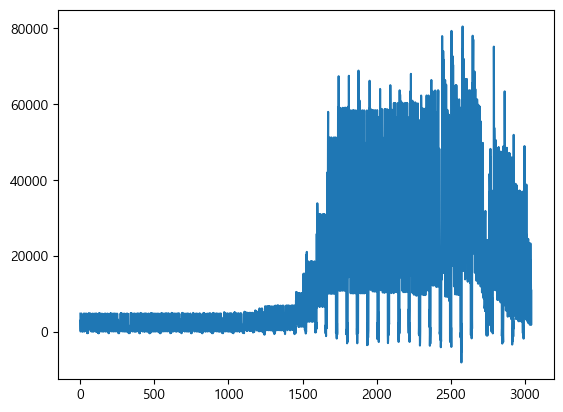

In [209]:
plt.plot(pred)

In [210]:
np.sqrt(mean_squared_error(y_valid_no, pred))

10676.53548436675

### train_test 4주로 나누기

In [231]:
train_tg
x_train_4= train_tg[train_tg["timestamp"]<"2023-02-03"].drop(columns = ["timestamp","supply"])
x_valid_4 = train_tg[train_tg["timestamp"]>="2023-02-03"].drop(columns = ["timestamp","supply"])
y_train_4, y_valid_4 = train_tg[train_tg["timestamp"]<"2023-02-03"]["supply"] ,train_tg[train_tg["timestamp"]>="2023-02-03"]["supply"]

In [236]:
### early stopping 
from xgboost import XGBRegressor
evals = [(x_valid_4, y_valid_4)]

xgb_wrapper = XGBRegressor(n_estimators = 1000, random_state = 2024, learning_rate = 0.01, max_leaves = 10)
xgb_wrapper.fit(x_train_4, y_train_4, early_stopping_rounds =500, eval_set = evals, eval_metric = "rmse", verbose=True)

[0]	validation_0-rmse:27331.73143
[1]	validation_0-rmse:27124.62899
[2]	validation_0-rmse:26921.36075
[3]	validation_0-rmse:26720.55167
[4]	validation_0-rmse:26520.77973
[5]	validation_0-rmse:26324.77911
[6]	validation_0-rmse:26131.13090
[7]	validation_0-rmse:25937.76930
[8]	validation_0-rmse:25756.17563
[9]	validation_0-rmse:25568.39370
[10]	validation_0-rmse:25382.54256
[11]	validation_0-rmse:25199.31333


[12]	validation_0-rmse:25017.97014
[13]	validation_0-rmse:24847.29254
[14]	validation_0-rmse:24660.66382
[15]	validation_0-rmse:24486.63680
[16]	validation_0-rmse:24322.06337
[17]	validation_0-rmse:24140.13516
[18]	validation_0-rmse:23961.08424
[19]	validation_0-rmse:23774.06379
[20]	validation_0-rmse:23616.55713
[21]	validation_0-rmse:23434.55821
[22]	validation_0-rmse:23254.72585
[23]	validation_0-rmse:23102.49428
[24]	validation_0-rmse:22926.01248
[25]	validation_0-rmse:22752.38732
[26]	validation_0-rmse:22581.28149
[27]	validation_0-rmse:22435.79452
[28]	validation_0-rmse:22278.12427
[29]	validation_0-rmse:22111.63468
[30]	validation_0-rmse:21976.14452
[31]	validation_0-rmse:21825.37854
[32]	validation_0-rmse:21664.49459
[33]	validation_0-rmse:21533.94371
[34]	validation_0-rmse:21377.85718
[35]	validation_0-rmse:21233.97846
[36]	validation_0-rmse:21101.52225
[37]	validation_0-rmse:20950.78956
[38]	validation_0-rmse:20811.65475
[39]	validation_0-rmse:20664.43402
[40]	validation_0-rm

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=10,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2024, ...)

In [245]:
pred_4 = xgb_wrapper.predict(x_valid_4)
for idx in range(len(pred_4)):
    if pred_4[idx]<0:
        pred_4[idx]=0
np.sqrt(mean_squared_error(y_valid_4, pred_4))

In [248]:
np.sqrt(mean_squared_error(y_valid_4, pred_4))

8210.361515474457

In [246]:
y_valid_4

7586     26424.5
1494     10930.0
15201    29968.0
10632     4960.0
9109     57626.0
          ...   
4568      3027.0
3045     35016.0
1522     10343.6
13706     3360.0
15229    26157.0
Name: supply, Length: 290, dtype: float64

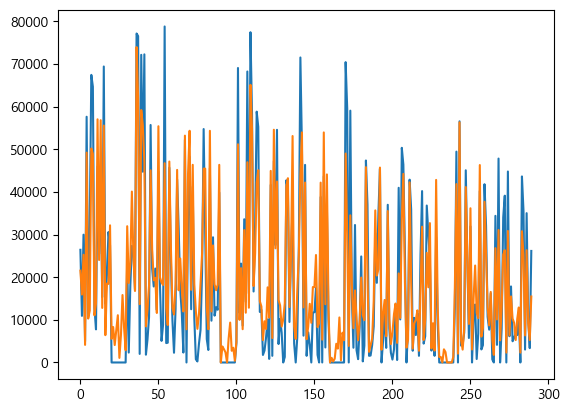

In [247]:
plt.plot(y_valid_4.tolist())
plt.plot(pred_4)

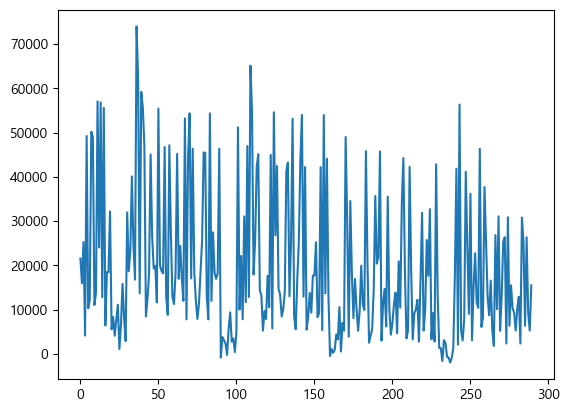

In [238]:
plt.plot(pred_4)